# Import Necessary libraries and load the dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
import time

In [2]:
data = pd.read_csv('ratings_Electronics.csv', names = ["userId", "productId", "rating", "timestamp"])
data.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Shape of the data

In [3]:
data.shape

(7824482, 4)

There are 7824482 rows and 4 columns in the dataset.

In [4]:
data.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

# Unique UserId and Product Id

In [5]:
unique_userId = data['userId'].nunique()
unique_productId = data['productId'].nunique()
print('Total number of unique Users:', unique_userId)
print('Total number of unique Products:', unique_productId)

Total number of unique Users: 4201696
Total number of unique Products: 476002


# Checking the presence of missing values

In [6]:
data.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

There is no missing values in any of the column.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


From above we can see that, mean of rating is less than median which stats that the distribution is negatively skewed.
Mean of timestamp is almost near to median which stats the distribution is symmetric.

# Checking the Outliers

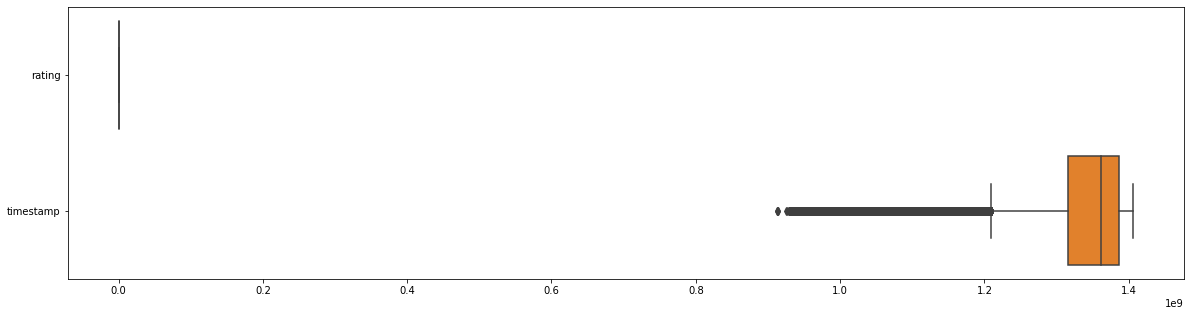

In [8]:
plt.figure(figsize =(20,5))
sns.boxplot(data = data, orient = 'h')

From the above boxplot we can see that there are outliers in timestamp column. But I will not fixed the outliers as i will be 
dropping timestamp which is mentioned in the problem statement.

# Pair plot that includes all the columns of dataframe:

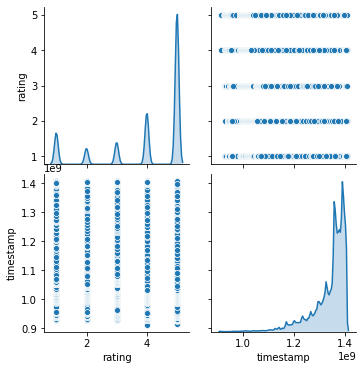

In [9]:
sns.pairplot(data, diag_kind = 'kde')

From above we can observe that most of the customers have given 5 rating .

# Checking the ratio of all 5 ratings

In [10]:
data['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

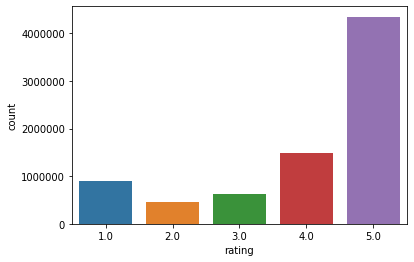

In [11]:
sns.countplot(data['rating'])

From the above countplot we observe that most of the people have given 5 rating. Least number of people have given 2 rating.
we also analysed that most of the products are liked by the people.


In [12]:
data.corr()

,rating,timestamp
rating,1.000000,0.041648
timestamp,0.041648,1.000000


# Dropping timestamp column:

In [13]:
data = data.drop(['timestamp'], axis =1)

Taking copy of dataframe before doing any manupulation with dataset .

In [14]:
data1 = data.copy()

In [15]:
data1.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


# Taking a subset of the dataset to make it less sparse/ denser.

Taking subset of users who have given 50 or more number of ratings: 

In [16]:
users_counts = data1['userId'].value_counts().rename('users_counts')
users_data = data1.merge(users_counts.to_frame(), left_on = 'userId', right_index = True)

In [17]:
subset_data = users_data[users_data.users_counts >= 50]
subset_data.head()

,userId,productId,rating,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


From above we can see that only those users who have given 50 or more number of ratings.

Taking subset of products which have received 10 or more number of ratings:

In [18]:
product_rating_counts = subset_data['productId'].value_counts().rename('product_rating_counts')
product_rating_data = subset_data.merge(product_rating_counts.to_frame(), left_on = 'productId', right_index = True)

In [19]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


In [20]:
amazon_data = product_rating_data.copy()

In [21]:
panda_data = amazon_data.drop(['users_counts','product_rating_counts'], axis =1)
panda_data.head()

,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


# Spliting the data randomly into train and test dataset (70:30 ratio)

In [22]:
reader = Reader(rating_scale =(1,5))
surprise_data = Dataset.load_from_df(panda_data[['userId','productId','rating']],reader)

In [23]:
trainset, testset = train_test_split(surprise_data, test_size = 0.30, random_state = 1)

# Building Popularity Recommender Model:

In two way I will be creating the Recommender model.
Using mean of product rating.
Using Ranking Based Algorithm.

In [24]:
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [25]:
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [26]:
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending = False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head()

,rating,prod_rating_count
productId,,
B00L3YHF6O,5.0,14
B00006HSML,5.0,10
B001TH7GUA,5.0,17
B000IJY8DS,5.0,17
B005LDLP8W,5.0,16


In [27]:
basic_popularity_model = prod_rating_count.sort_values(by =['prod_rating_count'],ascending = False)
basic_popularity_model.head()

,rating,prod_rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


Above is the list of top 5 popular products for the recommendation.

# Ranking - Based Algorithms

In [28]:
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace =True)
panda_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [29]:
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending =0, method ='first')

# get the top 5 recommendations
popularity_recommendations = panda_data_sort.head()
popularity_recommendations

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


In [30]:
# Using popularity based recommender model to make predictions
import warnings
warnings.filterwarnings('ignore')
def recommend(userId):
    user_recommendations = popularity_recommendations
    user_recommendations['userID'] = userId
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:]+cols[:-1]
    user_recommendations = user_recommendations[cols]
    
    return user_recommendations

In [31]:
find_recom = [15, 122, 55, 240,344] # This list is user choice
for i in find_recom:
    print("Here is the recommendation for the userId: %d/n" %(i))
    print(recommend(i))
    print("/n")

Here is the recommendation for the userId: 15/n
      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0
/n
Here is the recommendation for the userId: 122/n
      userID   productId  score  Rank
1592     122  B0088CJT4U    206   1.0
839      122  B003ES5ZUU    184   2.0
226      122  B000N99BBC    167   3.0
1552     122  B007WTAJTO    164   4.0
1577     122  B00829TIEK    149   5.0
/n
Here is the recommendation for the userId: 55/n
      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0
/n
Here is the recommendation for the userId: 240/n
      userID   productId  score  Rank
1592     240  B0088CJT4U    206   1.0
839      240  B003ES5ZUU    184   2.0

Top 5 popular products(B0088CJT4U,  B003ES5ZUU, B000N99BBC, B007WTAJTO, B00829TIEK).
Since this is a popularity-based recommender model, recommendationsremain the same for all users.It is not personalized to 
paricular user.

# Building Collaborative Filtering model:

For the collaborative filtering model I am going to use SVD, KNNWithMeans .

In [32]:
# Creating Model
svd_model = SVD(n_factors = 10, biased = False)
#Train the model on the trainset
svd_model.fit(trainset)

In [33]:
# predicting for test set
predictions_svd = svd_model.test(testset)

In [34]:
# compute RMSE
accuracy.rmse(predictions_svd)


RMSE: 1.1239


1.123881234805343

In [35]:
svd_cv = cross_validate(svd_model,surprise_data, measures =['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0217  1.0681  1.0109  1.0286  1.0431  1.0345  0.0198  
MAE (testset)     0.7782  0.8109  0.7660  0.7838  0.7922  0.7862  0.0150  
Fit time          1.48    1.43    1.38    1.41    1.40    1.42    0.03    
Test time         0.11    0.18    0.11    0.11    0.12    0.13    0.03    


In [36]:
# storing crossvalidation results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'] ,
                            svd_described['fit_time']['mean'],svd_described['test_time']['mean']]],
                         columns = ['Model', 'RMSE', 'MAE' ,'Fit Time', 'Test Time'])
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.034502,0.786213,1.419,0.127464


# KNNWithMeans User-user

In [37]:
# Create model 
knnMeansUU_model = KNNWithMeans(k = 60, sim_options ={'user_based': True})

In [38]:
# Train the model on trainset
knnMeansUU_model.fit(trainset)
# predict on testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures = ['RMSE','MAE'], cv = 5, verbose = True)

# storing crossvalidation results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'],knnMeansUU_described
                                       ['test_mae']['mean'],
                                      knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                                    columns = ['Model', 'RMSE','MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index = True)
cv_results


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9303  0.9277  0.9201  0.9250  0.9198  0.9246  0.0042  
MAE (testset)     0.6552  0.6546  0.6490  0.6454  0.6497  0.6508  0.0037  
Fit time          0.25    0.25    0.36    0.26    0.26    0.28    0.04    
Test time         0.81    0.87    1.08    0.82    0.86    0.89    0.10    


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.034502,0.786213,1.41900,0.127464
1,KNNWithMeans User-User,0.924589,0.650763,0.27629,0.889487


# KNNWithMeans Item-item

In [39]:
# Create model
knnMeansII_model = KNNWithMeans(k = 60, sim_options= {'user_based': False})

# Train the model on trainset
knnMeansII_model.fit(trainset)

# predict on test set
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE of algorithm KNNwithmeans item item on 5 split

knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures = ['RMSE','MAE'], cv = 5, verbose = True)

#Storing crossvalidation results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()

knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'],knnMeansII_described
                                       ['test_mae']['mean'],
                                      knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                                    columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansII_cv_results, ignore_index = True)

accuracy.rmse(prediction_knnMeansII, verbose = True)

cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9296  0.9194  0.9146  0.9310  0.9402  0.9270  0.0090  
MAE (testset)     0.6568  0.6455  0.6386  0.6552  0.6629  0.6518  0.0087  
Fit time          0.43    0.44    0.45    0.44    0.44    0.44    0.01    
Test time         1.02    1.05    1.08    0.98    1.01    1.03    0.04    
RMSE: 0.9367


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.034502,0.786213,1.419000,0.127464
1,KNNWithMeans User-User,0.924589,0.650763,0.276290,0.889487
2,KNNWithMeans Item-Item,0.926976,0.651822,0.441519,1.027465


# KNNBasic

In [40]:
# Creating Model
knnBasic_model = KNNBasic(k = 50, sim_options = {'user_based': False})

# Train the model on trainset
knnBasic_model.fit(trainset)

# predict on test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm knnBasic on 5 splits

knnBasic_cv = cross_validate(knnBasic_model, surprise_data,  measures = ['RMSE','MAE'], cv = 5, verbose = True)


# storing cossvalidation results in dataframe

knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()

knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                                     knnBasic_described['fit_time']['mean'],
                                     knnBasic_described['test_time']['mean']]],
                                     columns = ['Model', 'RMSE', 'MAE','Fit Time', 'Test Time'])
                                
                                    
cv_results = cv_results.append(knnBasic_cv_results, ignore_index = True)
                                
accuracy.rmse(prediction_knnBasic, verbose = True)
cv_results                                    
                                                                                                                         

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9931  0.9846  0.9649  0.9889  0.9807  0.9824  0.0097  
MAE (testset)     0.6972  0.6878  0.6785  0.6963  0.6863  0.6892  0.0069  
Fit time          0.46    0.39    0.38    0.39    0.38    0.40    0.03    
Test time         1.35    0.93    0.94    0.97    0.96    1.03    0.16    
RMSE: 0.9929


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.034502,0.786213,1.419000,0.127464
1,KNNWithMeans User-User,0.924589,0.650763,0.276290,0.889487
2,KNNWithMeans Item-Item,0.926976,0.651822,0.441519,1.027465
3,KNNBasic,0.982424,0.689224,0.400127,1.029446


# KNNWithZScore

In [41]:
# Create the model
knnZscore_model = KNNWithZScore(k = 60, sim_options = {'user_based': False})

# Train on the training set
knnZscore_model.fit(trainset)

# predict on test set
prediction_knnZscore = knnZscore_model.test(testset)
 
# Evaluating RMSE of algorithms KNNWithZscore
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures =['RMSE','MAE'], cv = 5, verbose = True)

# Storing Crossvalidation results in dataframe

knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZscore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']
                                      ['mean'],
                                     knnZscore_described['fit_time']['mean'],knnZscore_described['test_time']['mean']]],
                                   columns = ['Model', 'RMSE','MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index = True)

accuracy.rmse(prediction_knnZscore, verbose = True)

cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9431  0.9327  0.9519  0.9338  0.9472  0.9417  0.0075  
MAE (testset)     0.6568  0.6474  0.6601  0.6468  0.6565  0.6535  0.0054  
Fit time          0.61    0.61    0.61    0.62    0.76    0.64    0.06    
Test time         1.15    1.09    1.12    1.52    1.13    1.20    0.16    
RMSE: 0.9498


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.034502,0.786213,1.419000,0.127464
1,KNNWithMeans User-User,0.924589,0.650763,0.276290,0.889487
2,KNNWithMeans Item-Item,0.926976,0.651822,0.441519,1.027465
3,KNNBasic,0.982424,0.689224,0.400127,1.029446
4,KNNWithZscore,0.941727,0.653533,0.641136,1.202680


# Evaluation Results:

# Comparison of all algorithms on RMSE

From above algorithm comparisons we analyse that
KNNWithMeans user- user gives the best RMSE value.
KNNWithMeans user-user and item-item both gives the best MAE value.
KNNWithMeans is giving the best RMSE in collaborative Filtering Algorithms.
we also observe that the fit time and test time taken by knnwithmeans is less than other algorithms.

# Top - K(K =5) recommendations 

In [42]:
k = 5

Here I am using SVD algorithm to get the top 5 recommendations of new products for each user.

In [43]:
top_n = defaultdict(list)
def get_top_n(predictions, n =k):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key = lambda x:x[1], reverse = True)
            top_n[uid] = user_ratings[:n]
            
            return top_n
        
top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list, {'A28N2AWOVO2PB': [('B004CLYEFK', 5)]})

# Precision and recall at k = 5

In [44]:
def precision_recall_at_k(predictions, k=5, threshold = 3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
               user_ratings.sort(key = lambda x:x[0], reverse = True)
            
               n_rel = sum((true_r>= threshold) for (_, true_r) in user_ratings)
            
               n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k] )
            
               n_rel_and_rec_k = sum(((true_r>= threshold) and (est>= threshold))
                
                                                for (est, true_r) in user_ratings[:k])
                
               precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k !=0 else 1
            
               recalls[uid] =  n_rel_and_rec_k / n_rel if n_rel != 0 else 1
            
               return precisions, recalls
        
kf = KFold(n_splits = 5)
svd_model = SVD()
precs = []
recalls = []
for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    
    print('Precision :', sum(prec for prec in precisions.values())/ len(precisions))
    print('recalls:', sum(rec for rec in recalls.values())/ len(recalls))

Precision : 1.0
recalls: 1.0
Precision : 1.0
recalls: 1.0
Precision : 1.0
recalls: 1.0
Precision : 1.0
recalls: 1.0
Precision : 1.0
recalls: 1.0


I have calculated Precision and recall at k = 5. 
My precision at 5 in top -5 recommendation problem is 100%. This means  that 100% of the recommendation are relevent to the 
users.

My recall at 5 in top -5 recommendation problem is 100% . This means that 100% of the recommendation are relevant to the 
products.

# Summarise your insights.

The above EDA was analysed to understand the data in precise way and found that most of the customers have given 5 rating
The subset of data are selected based on users who have given 50 or more rating and the products which received 10 or more 
number of ratings .

In Popularity based model top 5 recommended products are displayed with repect to users.
This means same top 5 products will be recommended to each user.

SVD and K-NN based algorithms are selected to build Collaborative Filtering Model.
Obervation 1 :  KNNWithMeans is performing well .
Observation 2  KNNWithMeans user-user has given lowest RMSE. 

Therefore, we analyse that KNNwithMeans user-user model will be used to get the recommended products.